# Modeling explosive percolation

Replicating the following: https://journals.aps.org/pre/pdf/10.1103/PhysRevE.97.020301

First, need to implement three types of random growth process graphs:
* ER
* AP: Achlioptas : growth process (AP)
* DPR

In [1]:
# Auto-reloads external files any changes are automatically reflected
%load_ext autoreload
%autoreload 2

import numpy as np
import networkx as nx
import random
from tqdm import tqdm,tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Mechanistically, the DPR is analogous to the Achlioptas process, the difference being that the criteria used to evaluate edges is the product of node degrees (the number of edges attached to a node) rather than cluster sizes.

These are all undirected graphs, which should make the clustering easier.

Next steps:
1. Need to be able to calculate cluster size.
1. Need to get AP working
2. Need to be able to take steps forward in time while calculating cluster size

Make ER using networkx.

## Figure 1: Cluster sizes

In [2]:
class NetworkGeneration(object):
    def __init__(self,N,p,process_name,m=0):
        self.N = N # nodes, 3.6e5 in paper
        self.p = p
        self.m = m
        self.t = N*p # edges to add
        self.N_list = list(np.arange(self.N).astype(int))
        self.process = process_name    
    
    def build(self):
        if self.process=='ER': self.ER()
        elif self.process=='AP': self.AP()
        elif self.process=='DPR': self.DPR()
        else: print('build with a valid process')
            
    def calculate_edge_product(self,G,edge_tuple):
        return (G.degree[edge_tuple[0]]+1)*(G.degree[edge_tuple[1]]+1)

    def calculate_edge_cluster_sizes(self,G,edge_tuple):
        return len(nx.node_connected_component(G,edge_tuple[0])) + len(nx.node_connected_component(G,edge_tuple[1]))
    
    def ER(self):
        C = []
        G = nx.Graph()
        G.add_nodes_from(np.arange(self.N))
        pbar = tqdm_notebook(total=(self.t),desc="Building an ER network")
        while len(G.edges)<self.t:
            proposed_edge = (random.choice(self.N_list),random.choice(self.N_list))
            G.add_edge(proposed_edge[0],proposed_edge[1])
            C.append(len(max(nx.connected_component_subgraphs(G), key=len))/self.N)
            pbar.update(len(G.edges))
        pbar.close()
        self.C = C
        self.G = G
            
    def DPR(self):
        # DPR: goes to smallest product of the degrees of connection
        C = []
        G = nx.Graph()
        G.add_nodes_from(np.arange(self.N))
        pbar = tqdm_notebook(total=(self.t),desc="Building a DPR network")
        while len(G.edges)<self.t:
            proposed_edges = [(random.choice(self.N_list),random.choice(self.N_list)) for _ in range(self.m)]
            proposed_edge_weights = [self.calculate_edge_product(G,edge_tuple) for edge_tuple in proposed_edges]
            winning_edge = proposed_edges[proposed_edge_weights.index(min(proposed_edge_weights))]
            G.add_edge(winning_edge[0],winning_edge[1])
            C.append(len(max(nx.connected_component_subgraphs(G), key=len))/self.N)
            pbar.update(len(G.edges))
        pbar.close()
        self.C = C
        self.G = G
            
    def AP(self):
        # AP: goes to smallest sum of clusters connected to each node
        C = []
        G = nx.Graph()
        G.add_nodes_from(np.arange(self.N))
        pbar = tqdm_notebook(total=(self.t),desc="Building an AP network")
        while len(G.edges)<self.t:
            proposed_edges = [(random.choice(self.N_list),random.choice(self.N_list)) for _ in range(self.m)]
            proposed_edge_weights = [self.calculate_edge_cluster_sizes(G,edge_tuple) for edge_tuple in proposed_edges]
            winning_edge = proposed_edges[proposed_edge_weights.index(min(proposed_edge_weights))]
            G.add_edge(winning_edge[0],winning_edge[1])
            C.append(len(max(nx.connected_component_subgraphs(G), key=len))/self.N)
            pbar.update(len(G.edges))
        pbar.close()
        self.C = C
        self.G = G

In [3]:
N = 1e3 # nodes, 3.6e5 in paper
p = 1.0

In [5]:
N = 1e3 # nodes, 3.6e5 in paper
p = 1.0

test_ER = NetworkGeneration(N,p,'ER')
test_ER.build()

test_DPR = NetworkGeneration(N,p,'DPR',m=2)
test_DPR.build()

test_AP = NetworkGeneration(N,p,'AP',m=2)
test_AP.build()

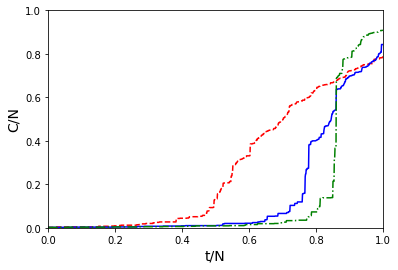

In [12]:
t_range = np.arange(N*p+1)/N
plt.plot(t_range,test_ER.C,'r--',t_range[:-1],test_DPR.C,'b-',t_range,test_AP.C[:-1],'g-.')
plt.ylabel('C/N')
plt.xlabel('t/N')
plt.ylim(0.0,1.0)
plt.xlim(0.0,1.0)
plt.show()

## Figure 2

The paper doesn't actually say what p value this is for.

In [4]:
def binary_search(G,C,start,end,largest_jump):
    # x-values
    midpoint = int((end+start)/2)
    
    # y-values
    head = C[int(start)]
    mid = C[midpoint]
    tail = C[int(end)]
        
    # If start and end are only one step removed from on another, then search is complete
    if abs(end-start)==1:
        if (tail-head)>largest_jump: largest_jump = (tail-head)
        return largest_jump
    # Check which side of the midpoint the largest jump is on
    elif (mid-head)>(tail-mid):
        if (mid-head)>(len(G.nodes)*0.01):
            largest_jump = (mid-head)
            return binary_search(G,C,int(start),int(midpoint),largest_jump)
    elif (tail-mid)>(len(G.nodes)*0.01):
        largest_jump = (tail-mid)
        return binary_search(G,C,int(midpoint),int(end),largest_jump)
    return largest_jump

In [ ]:
N_range = np.linspace(1e1, 5e2, num=5)

In [ ]:
# N_range = np.logspace(1e1, 5e2, num=5)
N_range = np.linspace(1e1, 5e2, num=5)

# First did 5, now try 1
p = 1.0

start = 0
F2_DPR_2_Cmax = []
F2_DPR_10_Cmax = []
F2_DPR_50_Cmax = []
F2_ER_Cmax = []

for N_test in N_range:
    print(N_test)
    end = N_test*p-1
    F2_ER = NetworkGeneration(N_test,p,'ER')
    F2_ER.build()
    F2_ER_Cmax.append(binary_search(F2_ER.G,[c*N_test for c in F2_ER.C],start,end,0)/N_test)
    F2_DPR_2 = NetworkGeneration(N_test,p,'DPR',m=2)
    F2_DPR_2.build()
    F2_DPR_2_Cmax.append(binary_search(F2_DPR_2.G,[c*N_test for c in F2_DPR_2.C],start,end,0)/N_test)
    F2_DPR_10 = NetworkGeneration(N_test,p,'DPR',m=10)
    F2_DPR_10.build()
    F2_DPR_10_Cmax.append(binary_search(F2_DPR_10.G,[c*N_test for c in F2_DPR_10.C],start,end,0)/N_test)
    F2_DPR_50 = NetworkGeneration(N_test,p,'DPR',m=50)
    F2_DPR_50.build()
    F2_DPR_50_Cmax.append(binary_search(F2_DPR_50.G,[c*N_test for c in F2_DPR_50.C],start,end,0)/N_test)

In [ ]:
plt.loglog(N_range,F2_DPR_2_Cmax,'bo-',N_range,F2_DPR_10_Cmax,'ro-',N_range,F2_DPR_50_Cmax,'go-')
plt.loglog(N_range,F2_ER_Cmax,'k-.')
plt.ylabel(r'${\Delta}C_{max}$/N')
plt.xlabel('N')
plt.ylim(5e-3,1e0)
plt.xlim(1e1,1e3)
plt.show()

## Figure 3
This p value is 5.

In [10]:
N = 1e3 # nodes, 3.6e5 in paper
p = 5

F3_ER = NetworkGeneration(N,p,'ER')
F3_ER.build()

F3_DPR = NetworkGeneration(N,p,'DPR',m=2)
F3_DPR.build()

F3_AP = NetworkGeneration(N,p,'AP',m=2)
F3_AP.build()

In [11]:
bins = np.arange(17)
ER_hist,_ = np.histogram([d/2 for n, d in F3_ER.G.degree()],bins=bins)
DPR_hist,_ = np.histogram([d/2 for n, d in F3_DPR.G.degree()],bins=bins)
AP_hist,_ = np.histogram([d/2 for n, d in F3_AP.G.degree()],bins=bins)

Need to come back and revisit this to remove the divide by 2 hack job...

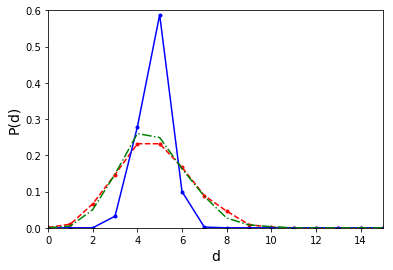

In [12]:
x = bins[:-1]
plt.plot(x,ER_hist/N,'r.--',x,DPR_hist/N,'b.-',x,AP_hist/N,'g-.')
plt.ylabel('P(d)')
plt.xlabel('d')
plt.ylim(0.0,0.6)
plt.xlim(0,15)
plt.show()

## Figure 4: Critical behavior
In this case, they don't give me m!
* need to calculate average cluster size; should be pretty straight-forward

In [33]:
N_range = np.linspace(1e1, 1e3, num=5)

# pc = 0.763
largest_cluster_a = []
average_cluster_size_a = []
largest_cluster_b = []
average_cluster_size_b = []
largest_cluster_c = []
average_cluster_size_c = []
for N_test in N_range:
    F4_DPR_c = NetworkGeneration(N_test,0.763,'DPR',m=2)
    F4_DPR_c.build()
    largest_cluster_c.append(max(F4_DPR_c.C))
    average_cluster_size_c.append(sum([len(s)**2/1e3 for s in list(nx.connected_components(F4_DPR_c.G))]))
    F4_DPR_a = NetworkGeneration(N_test,0.77,'DPR',m=2)
    F4_DPR_a.build()
    largest_cluster_a.append(max(F4_DPR_a.C))
    average_cluster_size_a.append(sum([len(s)**2/1e3 for s in list(nx.connected_components(F4_DPR_a.G))]))
    F4_DPR_b = NetworkGeneration(N_test,0.75,'DPR',m=2)
    F4_DPR_b.build()
    largest_cluster_b.append(max(F4_DPR_b.C))
    average_cluster_size_b.append(sum([len(s)**2/1e3 for s in list(nx.connected_components(F4_DPR_b.G))]))

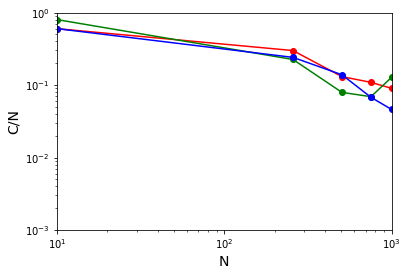

In [37]:
plt.loglog(N_range,largest_cluster_c,'ro-',N_range,largest_cluster_a,'go-',N_range,largest_cluster_b,'bo-')
plt.ylabel('C/N')
plt.xlabel('N')
plt.ylim(1e-3,1e0)
plt.xlim(1e1,1e3)
plt.show()

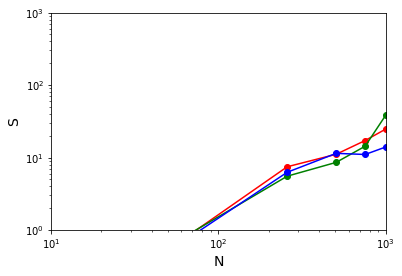

In [36]:
plt.loglog(N_range,average_cluster_size_c,'ro-',N_range,average_cluster_size_a,'go-',N_range,average_cluster_size_b,'bo-')
plt.ylabel('S')
plt.xlabel('N')
plt.ylim(1e0,1e3)
plt.xlim(1e1,1e3)
plt.show()